<a href="https://colab.research.google.com/github/gr3g-z/TCC-PUCSP-CDIA/blob/main/ProphetD1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.9.1-py3-none-any.whl (13 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached httpstan-4.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45.3 MB)
  Using cached pysimdjson-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached crashtest-0.3.1-py3-none-any.whl (7.0 kB)
  Using cached pastel-0.2.1-py2.py3-none-any.whl (6.0 kB)
  Using cached pylev-1.4.0-py2.py3-none-any.whl (6.1 kB)
  Using cached marshmallow-3.21.1-py3-none-any.w

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import re

In [4]:
jan = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_January_2019.csv')
fev = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_February_2019.csv')
mar = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_March_2019.csv')
abr = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_April_2019.csv')
mai = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_May_2019.csv')
jun = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_June_2019.csv')
jul = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_July_2019.csv')
ago = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_August_2019.csv')
sep = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_September_2019.csv')
out = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_October_2019.csv')
nov = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_November_2019.csv')
dez = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_December_2019.csv')

In [5]:
df = pd.concat([jan, fev, mar, abr, mai, jun, jul, ago, sep, out, nov, dez])
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,141234,iPhone,1,700,01/22/19 21:25,"944 Walnut St, Boston, MA 02215"
1,141235,Lightning Charging Cable,1,14.95,01/28/19 14:15,"185 Maple St, Portland, OR 97035"
2,141236,Wired Headphones,2,11.99,01/17/19 13:33,"538 Adams St, San Francisco, CA 94016"
3,141237,27in FHD Monitor,1,149.99,01/05/19 20:33,"738 10th St, Los Angeles, CA 90001"
4,141238,Wired Headphones,1,11.99,01/25/19 11:59,"387 10th St, Austin, TX 73301"


In [6]:
df = df.dropna(axis = 0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186305 entries, 0 to 25116
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 9.9+ MB


In [8]:
# Converta a coluna 'Order Date' para datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%y %H:%M', errors='coerce')

In [9]:
df = df.dropna(subset=['Order Date'])

In [10]:
df['Quantity Ordered'] = df['Quantity Ordered'].astype(int)
df['Price Each'] = df['Price Each'].astype(float)

In [11]:
df_cleaned = df.copy()

# Converta a coluna 'Order Date' para datetime
df_cleaned['Order Date'] = pd.to_datetime(df_cleaned['Order Date'], format='%m/%d/%y %H:%M', errors='coerce')

df_cleaned['Quantity Ordered'] = df_cleaned['Quantity Ordered'].astype(int)
df_cleaned['Price Each'] = df_cleaned['Price Each'].astype(float)

# Remova as linhas com valores não convertíveis
df_cleaned = df_cleaned.dropna(subset=['Order Date'])

In [12]:
df_cleaned['Total Spent'] = df['Quantity Ordered'] * df['Price Each']

In [13]:
df_cleaned

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Total Spent
0,141234,iPhone,1,700.00,2019-01-22 21:25:00,"944 Walnut St, Boston, MA 02215",700.00
1,141235,Lightning Charging Cable,1,14.95,2019-01-28 14:15:00,"185 Maple St, Portland, OR 97035",14.95
2,141236,Wired Headphones,2,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016",23.98
3,141237,27in FHD Monitor,1,149.99,2019-01-05 20:33:00,"738 10th St, Los Angeles, CA 90001",149.99
4,141238,Wired Headphones,1,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301",11.99
...,...,...,...,...,...,...,...
25112,319666,Lightning Charging Cable,1,14.95,2019-12-11 20:58:00,"14 Madison St, San Francisco, CA 94016",14.95
25113,319667,AA Batteries (4-pack),2,3.84,2019-12-01 12:01:00,"549 Willow St, Los Angeles, CA 90001",7.68
25114,319668,Vareebadd Phone,1,400.00,2019-12-09 06:43:00,"273 Wilson St, Seattle, WA 98101",400.00
25115,319669,Wired Headphones,1,11.99,2019-12-03 10:39:00,"778 River St, Dallas, TX 75001",11.99


In [14]:
produto_LightningCable = 'Wired Headphones'
# Filtrar o DataFrame original para incluir apenas o produto específico
df = df_cleaned[df_cleaned['Product'] == produto_LightningCable].copy()
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Total Spent
2,141236,Wired Headphones,2,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016",23.98
4,141238,Wired Headphones,1,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301",11.99
36,141270,Wired Headphones,1,11.99,2019-01-27 23:10:00,"469 Hill St, San Francisco, CA 94016",11.99
39,141273,Wired Headphones,2,11.99,2019-01-29 12:04:00,"994 13th St, Boston, MA 02215",23.98
42,141275,Wired Headphones,1,11.99,2019-01-07 16:06:00,"610 Walnut St, Austin, TX 73301",11.99
...,...,...,...,...,...,...,...
25063,319618,Wired Headphones,1,11.99,2019-12-16 15:18:00,"773 5th St, Boston, MA 02215",11.99
25068,319623,Wired Headphones,1,11.99,2019-12-11 19:11:00,"164 Meadow St, Los Angeles, CA 90001",11.99
25083,319637,Wired Headphones,1,11.99,2019-12-31 22:14:00,"641 Adams St, Portland, OR 97035",11.99
25101,319655,Wired Headphones,1,11.99,2019-12-28 19:38:00,"614 Cherry St, Austin, TX 73301",11.99


In [15]:
df['Product'].unique()

array(['Wired Headphones'], dtype=object)

In [16]:
df.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
Total Spent         0
dtype: int64

In [17]:
# Converta a coluna 'Order Date' para o tipo de dado de data
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Crie uma nova coluna 'Date' que contenha apenas a data, ignorando a hora
df['Date'] = df['Order Date'].dt.date

# Agora, agrupe os dados por 'Date' e some a 'Quantity Ordered' em cada grupo
vendas_por_dia_cabo = df.groupby('Date')['Quantity Ordered'].sum()

# Resetando o índice para que a data se torne uma coluna
df2 = vendas_por_dia_cabo.reset_index()

# Renomeando as colunas
df2.columns = ['Data', 'Quantidade Vendida']

In [18]:
df2

,Data,Quantidade Vendida
0,2019-01-01,31
1,2019-01-02,35
2,2019-01-03,31
3,2019-01-04,28
4,2019-01-05,47
...,...,...
361,2019-12-28,95
362,2019-12-29,95
363,2019-12-30,77
364,2019-12-31,90


In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Data                366 non-null    object
 1   Quantidade Vendida  366 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [20]:
#df2 = df.drop(['Order ID','Product','Quantity Ordered','Price Each','Purchase Address'], axis = 1)

In [21]:
df2 = df2.rename(columns={'Data': 'ds', 'Quantidade Vendida': 'y'})

In [22]:
# Divisão para treino e teste
proporcao_treino = 0.8  # 80% de dados para treino
tamanho_treino = int(len(df2) * proporcao_treino)

In [23]:
# Separação dos dados para treino e teste
df_train = df2.iloc[:tamanho_treino]  # Dados de treino
df_test = df2.iloc[tamanho_treino:]   # Dados de teste

# Ajustes do modelo Prophet
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.add_country_holidays(country_name='US')
model.fit(df_train)

# Dataframe com as datas futuras (180 dias)
future = model.make_future_dataframe(periods=180)

# Previsão
forecast = model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp83v9rcn2/rzgixeo6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83v9rcn2/r5k4t338.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70108', 'data', 'file=/tmp/tmp83v9rcn2/rzgixeo6.json', 'init=/tmp/tmp83v9rcn2/r5k4t338.json', 'output', 'file=/tmp/tmp83v9rcn2/prophet_modelfr1i2pr9/prophet_model-20240426035755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


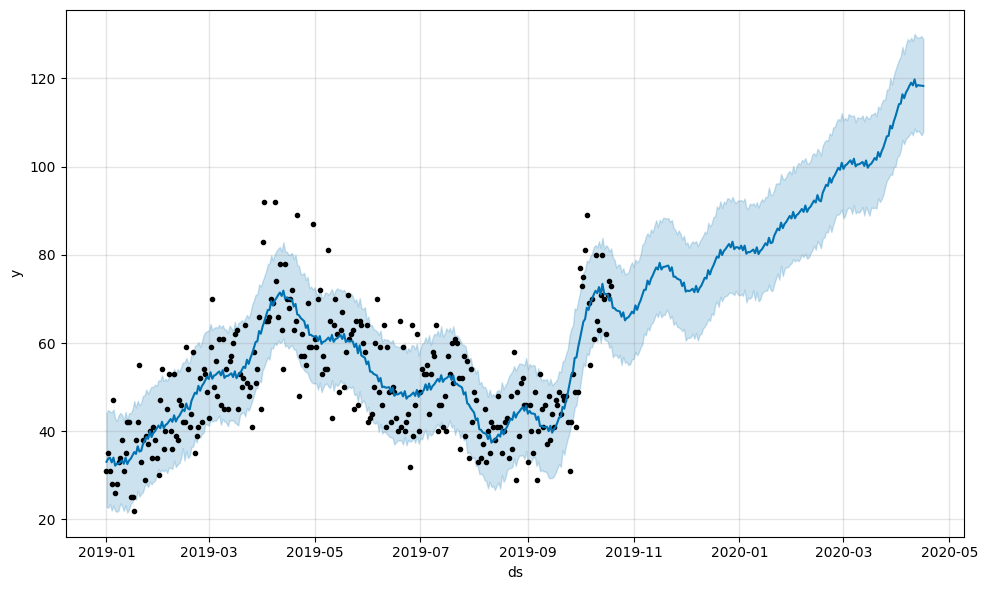

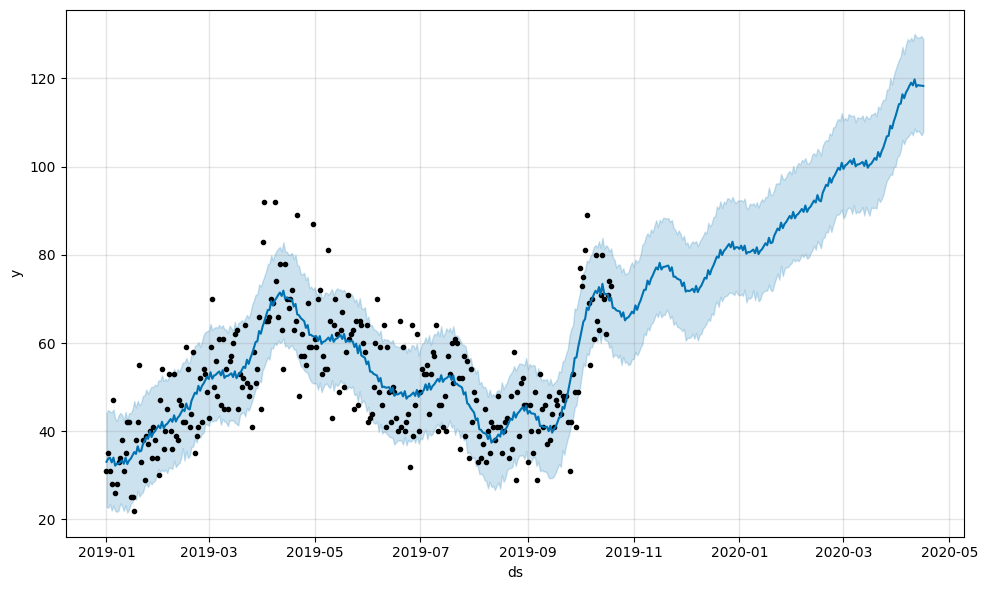

In [28]:
model.plot(forecast)

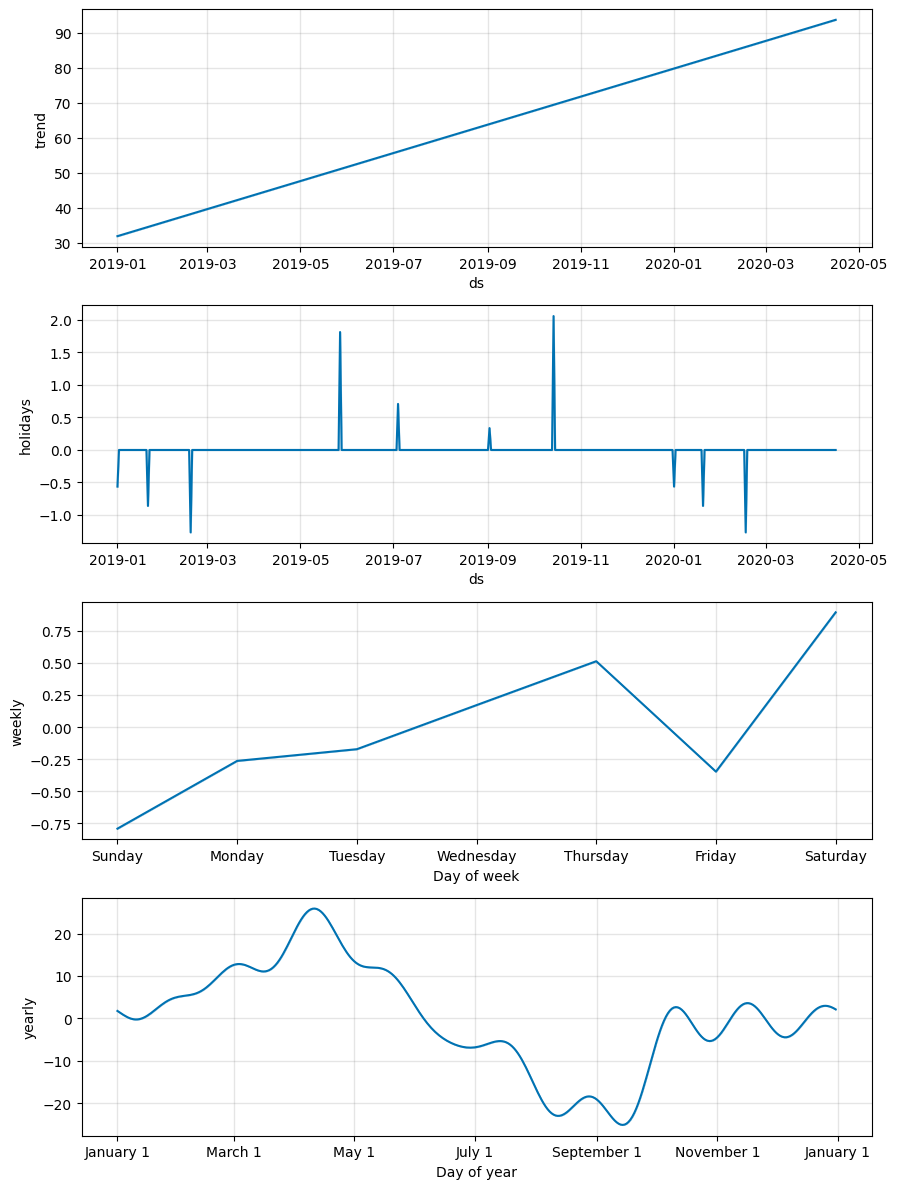

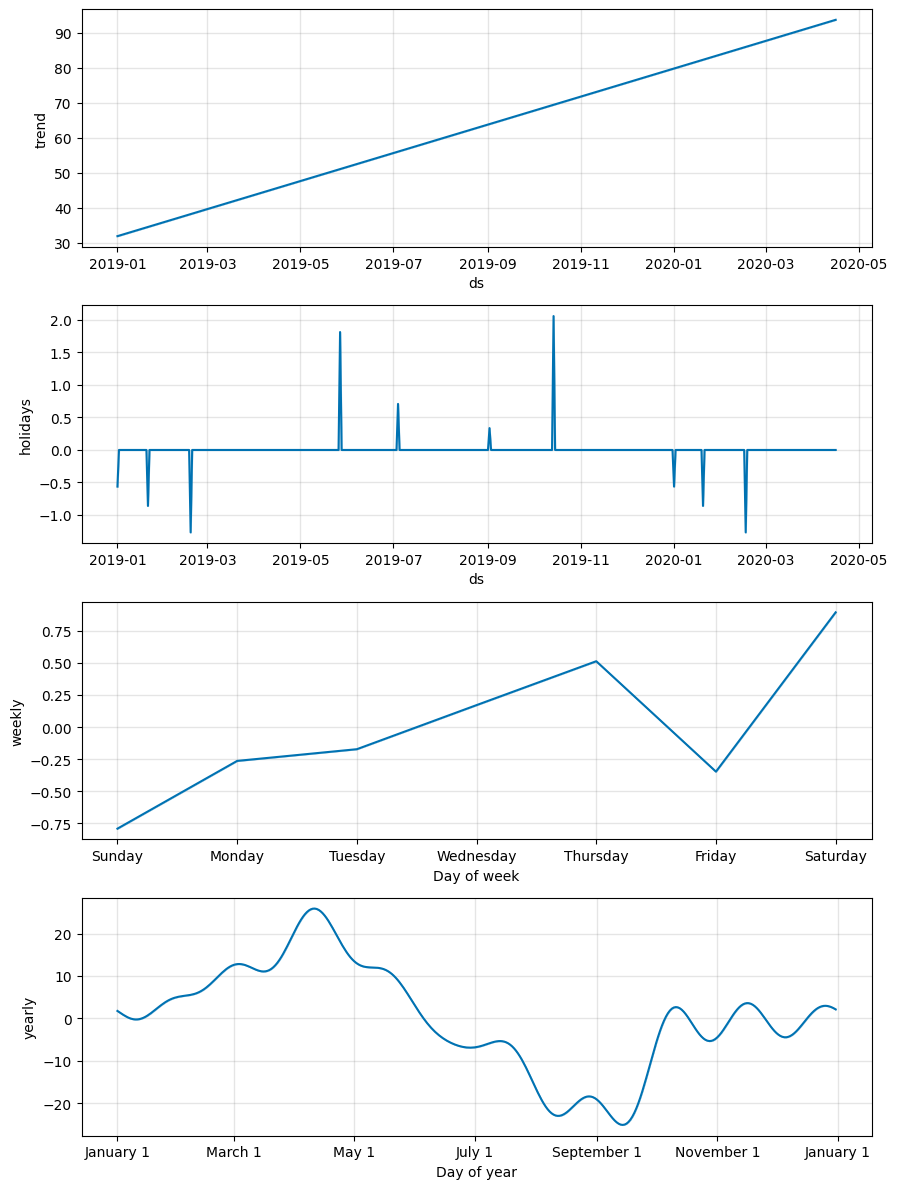

In [27]:
model.plot_components(forecast)

In [25]:
from sklearn.metrics import mean_absolute_error

# Calculando a acurácia
y_true = df_test['y'].values
y_pred = forecast['yhat'].iloc[-len(df_test):].values
accuracy = 1 - mean_absolute_error(y_true, y_pred)/df_test['y'].mean()

print("Acurácia:", accuracy)

# Calculando o MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return (np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape)


Acurácia: 0.6427794640930615
MAPE: 75.54236352462792
